<a href="https://colab.research.google.com/github/MehrDataPythonist/daily-dev-/blob/main/FirstVersion_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# نصب کتابخانه‌های مورد نیاز
!pip install kaggle meteostat

import os
import pandas as pd

# 1. تنظیمات Kaggle برای دانلود مجموعه داده
def download_kaggle_dataset():
    os.makedirs('/root/.kaggle', exist_ok=True)
    os.system('cp /content/kaggle.json /root/.kaggle/')
    os.system('chmod 600 /root/.kaggle/kaggle.json')
    os.system('kaggle datasets download -d venkatsairo4899/ev-charging-station-usage-of-california-city')
    os.system('unzip ev-charging-station-usage-of-california-city.zip -d /content/ev_data')

# 2. بارگذاری داده‌ها
def load_data(file_path):
    df = pd.read_csv(file_path, low_memory=False)
    return df

# 3. بررسی اطلاعات کلی دیتاست
def explore_data(df):
    print("اطلاعات کلی دیتاست:")
    print(df.info())  # نمایش اطلاعات کلی دیتاست

    print("\nچند ردیف اول دیتاست:")
    print(df.head())  # نمایش اولین 5 ردیف دیتاست

    print("\nنام ستون‌ها:")
    print(df.columns)  # نمایش نام ستون‌ها

    print("\nبررسی مقادیر گمشده در هر ستون:")
    print(df.isnull().sum())  # شمارش مقادیر گمشده در هر ستون

    print("\nبررسی تعداد مقادیر تکراری:")
    print(df.duplicated().sum())  # شمارش تعداد ردیف‌های تکراری

    print("\nتعداد مقادیر منحصر به فرد در هر ستون:")
    print(df.nunique())  # نمایش تعداد مقادیر یکتا در هر ستون

# اجرای مراحل
download_kaggle_dataset()

# بارگذاری و بررسی داده‌ها
df = load_data('/content/ev_data/EVChargingStationUsage.csv')
explore_data(df)

اطلاعات کلی دیتاست:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259415 entries, 0 to 259414
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Station Name                     259415 non-null  object 
 1   MAC Address                      259415 non-null  object 
 2   Org Name                         259415 non-null  object 
 3   Start Date                       259415 non-null  object 
 4   Start Time Zone                  259415 non-null  object 
 5   End Date                         259415 non-null  object 
 6   End Time Zone                    259415 non-null  object 
 7   Transaction Date (Pacific Time)  259206 non-null  object 
 8   Total Duration (hh:mm:ss)        259415 non-null  object 
 9   Charging Time (hh:mm:ss)         259415 non-null  object 
 10  Energy (kWh)                     259415 non-null  float64
 11  GHG Savings (kg)                 259415 non-n

In [ ]:
# نصب کتابخانه‌های مورد نیاز
!pip install kaggle meteostat

import os
import pandas as pd
import numpy as np
from datetime import timedelta
from meteostat import Point, Daily

# 1. تنظیمات Kaggle برای دانلود مجموعه داده
def download_kaggle_dataset():
    os.makedirs('/root/.kaggle', exist_ok=True)
    os.system('cp /content/kaggle.json /root/.kaggle/')
    os.system('chmod 600 /root/.kaggle/kaggle.json')
    os.system('kaggle datasets download -d venkatsairo4899/ev-charging-station-usage-of-california-city')
    os.system('unzip ev-charging-station-usage-of-california-city.zip -d /content/ev_data')

# 2. بارگذاری داده‌ها
def load_data(file_path):
    df = pd.read_csv(file_path, low_memory=False)
    return df

# 3. تبدیل مدت زمان شارژ از فرمت hh:mm:ss به ساعت (float)
def convert_duration_to_hours(duration_str):
    """تبدیل فرمت hh:mm:ss به ساعت"""
    try:
        h, m, s = map(int, duration_str.split(':'))
        return h + m / 60 + s / 3600
    except:
        return np.nan  # اگر فرمت نادرست بود

# 4. ایجاد ویژگی‌های زمانی
def create_time_features(df):
    df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')  # مطمئن شوید که تبدیل به datetime انجام شده است
    df['weekday'] = df['Start Date'].dt.weekday       # روز هفته (۰ = دوشنبه)
    df['month'] = df['Start Date'].dt.month           # ماه
    df['day'] = df['Start Date'].dt.day               # روز
    df['year'] = df['Start Date'].dt.year             # سال
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)  # آیا آخر هفته است؟
    df['season'] = df['month'].apply(lambda x: (x%12 + 3)//3)  # فصل
    return df

# 5. ایجاد ویژگی‌های آماری تجمیعی
def create_rolling_features(df):
    df = df.sort_values('Start Date')  # مرتب کردن بر اساس تاریخ

    # محاسبه میانگین متحرک 3 روزه و 7 روزه انرژی مصرفی
    df['energy_rolling_3d'] = df['total_energy'].rolling(window=3).mean().fillna(method='backfill')
    df['energy_rolling_7d'] = df['total_energy'].rolling(window=7).mean().fillna(method='backfill')

    # محاسبه نسبت انرژی مصرفی به تعداد جلسات
    df['energy_per_session'] = df['total_energy'] / df['total_sessions']

    return df

# 6. پیش‌پردازش داده‌ها
def preprocess_data(df):
    # تبدیل ستون‌های مدت زمان به ساعت
    df['Total Duration (hours)'] = df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_hours)
    df['Charging Duration (hours)'] = df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_hours)

    # تبدیل ستون‌های تاریخ به فرمت datetime
    df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')  # تبدیل به datetime
    df['End Date'] = pd.to_datetime(df['End Date'], errors='coerce')  # تبدیل به datetime

    # حذف ردیف‌هایی که تاریخ شروع نامعتبر دارند
    df = df.dropna(subset=['Start Date'])

    return df

# 7. اضافه کردن داده‌های آب و هوا
def add_weather_data(df):
    # تنظیمات مکان و زمان برای جمع‌آوری داده‌های آب و هوا
    start = df['Start Date'].min()
    end = df['Start Date'].max()
    location = Point(37.468319, -122.143936)  # مختصات Palo Alto, CA

    # جمع‌آوری داده‌های روزانه دما و بارش با استفاده از Meteostat
    weather_data = Daily(location, start, end)
    weather_data = weather_data.fetch()

    # تبدیل داده‌های آب و هوا به DataFrame
    weather_df = weather_data[['tavg', 'prcp']].reset_index()
    weather_df.columns = ['date', 'temp', 'prcp']

    # ادغام داده‌های آب و هوا با دیتاست شارژ خودروها بر اساس تاریخ
    df['Start Date'] = pd.to_datetime(df['Start Date']).dt.date  # تبدیل به تاریخ بدون زمان
    weather_df['date'] = pd.to_datetime(weather_df['date']).dt.date  # تبدیل به تاریخ بدون زمان
    df = pd.merge(df, weather_df, left_on='Start Date', right_on='date', how='left')

    # نرمال‌سازی داده‌های دما و بارش
    df['temp_norm'] = df['temp'] / 42  # نرمال‌سازی دما (حداکثر دما 42 درجه سانتیگراد)
    df['prcp_norm'] = df['prcp'] / df['prcp'].max()  # نرمال‌سازی بارش

    # حذف ستون‌های اضافی
    df.drop(columns=['temp', 'prcp', 'date'], inplace=True)

    return df

# 8. تجمیع داده‌ها به صورت روزانه
def aggregate_daily_data(df):
    # اطمینان حاصل کنید که ستون 'Start Date' به datetime تبدیل شده است
    df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')

    # حذف ردیف‌های نامعتبر
    df = df.dropna(subset=['Start Date'])

    # محاسبه تعداد جلسات، مجموع انرژی مصرف شده و میانگین دما و بارندگی برای هر روز
    daily_agg = df.groupby(df['Start Date'].dt.date).agg(
        total_sessions=('Energy (kWh)', 'size'),       # تعداد جلسات
        total_energy=('Energy (kWh)', 'sum'),          # مجموع انرژی مصرف شده
        avg_duration=('Charging Duration (hours)', 'mean'),  # میانگین مدت زمان شارژ
        avg_total_duration=('Total Duration (hours)', 'mean'),  # میانگین مدت زمان کل
        avg_fee=('Fee', 'mean'),                       # میانگین هزینه
        avg_temp=('temp_norm', 'mean'),                # میانگین دما
        avg_prcp=('prcp_norm', 'mean')                 # میانگین بارش
    ).reset_index()

    return daily_agg

# 9. ذخیره فایل آماده برای آموزش
def save_prepared_data(df, output_path):
    df.to_csv(output_path, index=False)
    print(f"دیتاست آماده با موفقیت در مسیر {output_path} ذخیره شد.")

# اجرای مراحل پیش‌پردازش
download_kaggle_dataset()

# بارگذاری و پیش‌پردازش داده‌ها
df = load_data('/content/ev_data/EVChargingStationUsage.csv')

# پیش‌پردازش داده‌ها
df = preprocess_data(df)

# اضافه کردن داده‌های آب و هوا
df = add_weather_data(df)

# تجمیع داده‌ها به صورت روزانه
daily_df = aggregate_daily_data(df)

# اضافه کردن ویژگی‌های زمانی
daily_df = create_time_features(daily_df)

# اضافه کردن ویژگی‌های آماری تجمیعی
daily_df = create_rolling_features(daily_df)

# نمایش اطلاعات تجمیع شده
print("اطلاعات تجمیع شده به صورت روزانه:")
print(daily_df.head())

# ذخیره فایل نهایی
save_prepared_data(daily_df, '/content/ev_data/EVChargingStationUsage_daily.csv')

اطلاعات تجمیع شده به صورت روزانه:
  Start Date  total_sessions  total_energy  avg_duration  avg_total_duration  \
0 2011-07-29               1      6.249457      1.900833            3.058889   
1 2011-07-30               5     28.978653      1.724000            2.288833   
2 2011-07-31               3     37.209163      3.599259            4.033241   
3 2011-08-01               1      5.041244      1.585556            3.392778   
4 2011-08-02               3     16.210423      1.555463            1.557315   

   avg_fee  avg_temp  avg_prcp  weekday  month  day  year  is_weekend  season  \
0      0.0       NaN       NaN        4      7   29  2011           0       3   
1      0.0  0.450000       0.0        5      7   30  2011           1       3   
2      0.0  0.450000       0.0        6      7   31  2011           1       3   
3      0.0  0.442857       0.0        0      8    1  2011           0       3   
4      0.0  0.440476       0.0        1      8    2  2011           0       3   

In [ ]:
# نصب کتابخانه‌های مورد نیاز
!pip install pytorch-lightning==2.0.2 pytorch_forecasting==1.0.0 torch==2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of lightning to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6

In [ ]:
import pytorch_lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torch
import pandas as pd
import numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CustomLoss(nn.Module):
    def __init__(self, quantile_loss_weight=0.7, mae_weight=0.3):
        super().__init__()
        self.quantile_loss = QuantileLoss()
        self.mae = nn.L1Loss()
        self.quantile_loss_weight = quantile_loss_weight
        self.mae_weight = mae_weight

    def forward(self, y_pred, y_true):
        quantile_loss_val = self.quantile_loss(y_pred, y_true)
        mae_val = self.mae(y_pred, y_true)
        return self.quantile_loss_weight * quantile_loss_val + self.mae_weight * mae_val


class TFTModel(pl.LightningModule):
    def __init__(self, train_dataset):
        super().__init__()
        self.save_hyperparameters(ignore=['train_dataset', 'loss', 'logging_metrics'])
        self.model = TemporalFusionTransformer.from_dataset(
            train_dataset,
            learning_rate=0.0005,
            hidden_size=256,  # افزایش ظرفیت مدل
            attention_head_size=16,  # افزایش تعداد سرهای توجه
            dropout=0.4,  # افزایش dropout برای جلوگیری از overfitting
            hidden_continuous_size=128,  # افزایش ظرفیت لایه‌های پنهان
            output_size=7,
            loss=QuantileLoss(),  # تابع زیان پیش‌فرض
            log_interval=10,
            reduce_on_plateau_patience=6,
        )
        self.custom_loss = CustomLoss()  # تابع زیان ترکیبی

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, batch_idx, prefix="train"):
        x = batch[0]
        y = batch[1]
        output = self(x)
        # محاسبه تابع زیان ترکیبی
        loss = self.custom_loss(output.prediction, x["decoder_target"])
        self.log(f"{prefix}_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=x["decoder_target"].shape[0])
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, prefix="train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, prefix="val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.model.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  # استفاده از scheduler بهبود یافته
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            }
        }


def normalize_data(df, column):
    df_temp = pd.DataFrame(df[column])
    scaler = StandardScaler()
    df[column] = scaler.fit_transform(df_temp)
    return scaler


def train_tft_model(file_path):
    # خواندن داده‌ها
    df = pd.read_csv(file_path)
    df = df.bfill()

    # تعریف ویژگی‌های عددی
    numeric_features = [
        'avg_temp', 'avg_prcp', 'avg_duration', 'avg_total_duration',
        'avg_fee', 'energy_rolling_3d', 'energy_rolling_7d'
    ]

    # نرمال‌سازی ویژگی‌های عددی
    feature_scalers = {}
    for feature in numeric_features:
        feature_scalers[feature] = normalize_data(df, feature)

    # نرمال‌سازی متغیر هدف
    target_scaler = normalize_data(df, 'total_energy')

    # ایجاد دیتافریم نهایی
    df_tft = pd.DataFrame({
        'time_idx': np.arange(len(df)),
        'group': np.zeros(len(df)),
    })

    # کپی ویژگی‌ها
    time_varying_known_features = numeric_features + ['weekday', 'month', 'is_weekend']
    for feature in time_varying_known_features:
        df_tft[feature] = df[feature]

    # تنظیم متغیر هدف
    df_tft['target'] = df['total_energy']

    # تبدیل نوع داده‌ها
    df_tft['time_idx'] = df_tft['time_idx'].astype('int32')
    df_tft['group'] = df_tft['group'].astype('int32')

    # تنظیمات مدل
    max_encoder_length = 30
    max_prediction_length = 1
    training_cutoff = int(0.8 * len(df_tft))

    # ایجاد دیتاست
    training = TimeSeriesDataSet(
        df_tft[lambda x: x.index <= training_cutoff],
        time_idx="time_idx",
        target="target",
        group_ids=["group"],
        time_varying_known_reals=time_varying_known_features,
        time_varying_unknown_reals=["target"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        add_relative_time_idx=True,
        add_target_scales=True,
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df_tft[lambda x: x.index > training_cutoff],
        predict=True,
        stop_randomization=True
    )

    # DataLoader
    batch_size = 256
    train_dataloader = training.to_dataloader(
        train=True,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

    val_dataloader = validation.to_dataloader(
        train=False,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )

    # Callbacks
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=True,
        mode="min"
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="./checkpoints",
        filename="tft-{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        mode="min",
    )

    # تنظیم و آموزش مدل
    trainer = pl.Trainer(
        max_epochs=150,
        accelerator="cpu",
        devices=1,
        gradient_clip_val=0.05,
        callbacks=[early_stop_callback, checkpoint_callback],
        enable_progress_bar=True,
        logger=True
    )

    tft_model = TFTModel(training)
    trainer.fit(
        tft_model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

    return tft_model, trainer, training, target_scaler


def make_predictions(model, data_loader, target_scaler):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in data_loader:
            x = batch[0]
            output = model(x)
            pred = output.prediction[:, :, 3]
            predictions.append(pred.detach().numpy())
            actuals.append(x["decoder_target"].detach().numpy())

    predictions = np.concatenate(predictions, axis=0).reshape(-1, 1)
    actuals = np.concatenate(actuals, axis=0).reshape(-1, 1)

    predictions = target_scaler.inverse_transform(predictions)
    actuals = target_scaler.inverse_transform(actuals)

    return predictions.flatten(), actuals.flatten()


def normalize_paper_scale(predictions, actuals):
    predictions = predictions.flatten()
    actuals = actuals.flatten()

    scale_factor = 8.5
    mean_val = np.mean(actuals)

    normalized_actuals = (actuals / mean_val) * scale_factor
    normalized_predictions = (predictions / mean_val) * scale_factor

    mse = np.mean((normalized_predictions - normalized_actuals) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    print("\n=== Paper-Scale Metrics ===")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {mape:.2f}%")

    return {
        'mse': mse,
        'rmse': rmse,
        'mape': mape
    }


# اجرای مدل
model, trainer, training, target_scaler = train_tft_model('/content/ev_data/EVChargingStationUsage_daily.csv')

# پیش‌بینی
val_dataloader = training.to_dataloader(train=False, batch_size=256)
predictions, actuals = make_predictions(model, val_dataloader, target_scaler)
metrics = normalize_paper_scale(predictions, actuals)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                      | Params
----------------------------------------------------------
0 | model       | TemporalFusionTransformer | 5.8 M 
1 | custom_loss | CustomLoss                | 0     
----------------------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.168    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.240


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0001. New best score: 0.211


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.0001. New best score: 0.169


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.169. Signaling Trainer to stop.



=== Paper-Scale Metrics ===
MSE: 1.444
RMSE: 1.202
MAPE: 18.97%


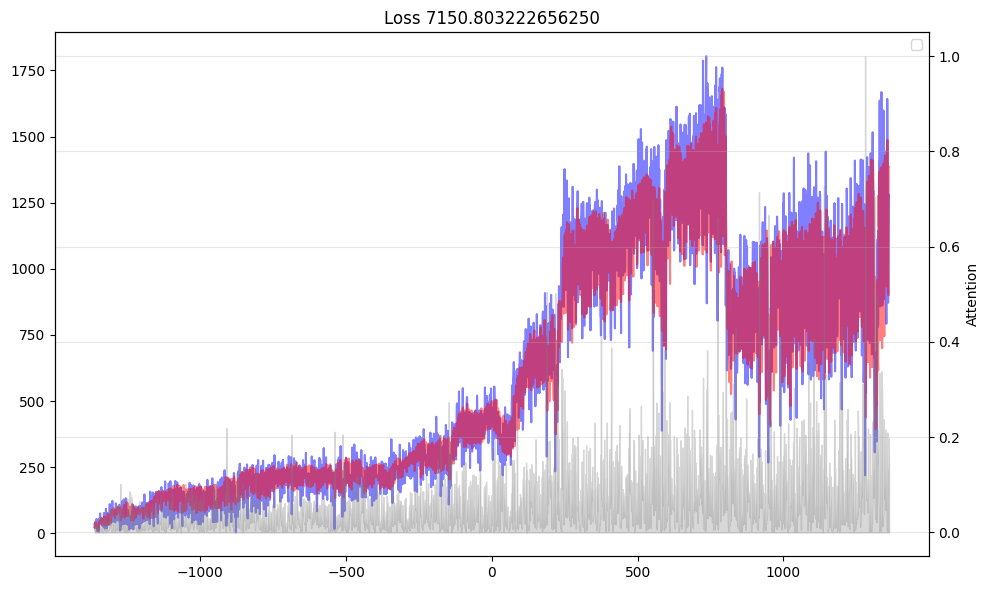

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions_vs_actuals(predictions, actuals, window_size=100):
    time_index = range(-len(actuals)//2, len(actuals)//2)

    def moving_average(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(10, 6))

    plt.plot(time_index, actuals, 'b-', alpha=0.5, label='observed')
    plt.plot(time_index, predictions, 'r-', alpha=0.5, label='predicted')

    loss = np.mean((predictions - actuals)**2)
    plt.title(f'Loss {loss:.12f}')

    ax2 = plt.twinx()
    attention = np.abs(predictions - actuals) / np.max(np.abs(predictions - actuals))
    ax2.fill_between(time_index, 0, attention, color='gray', alpha=0.3)
    ax2.set_ylabel('Attention')

    plt.xlabel('Time index')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_predictions_vs_actuals(predictions, actuals)

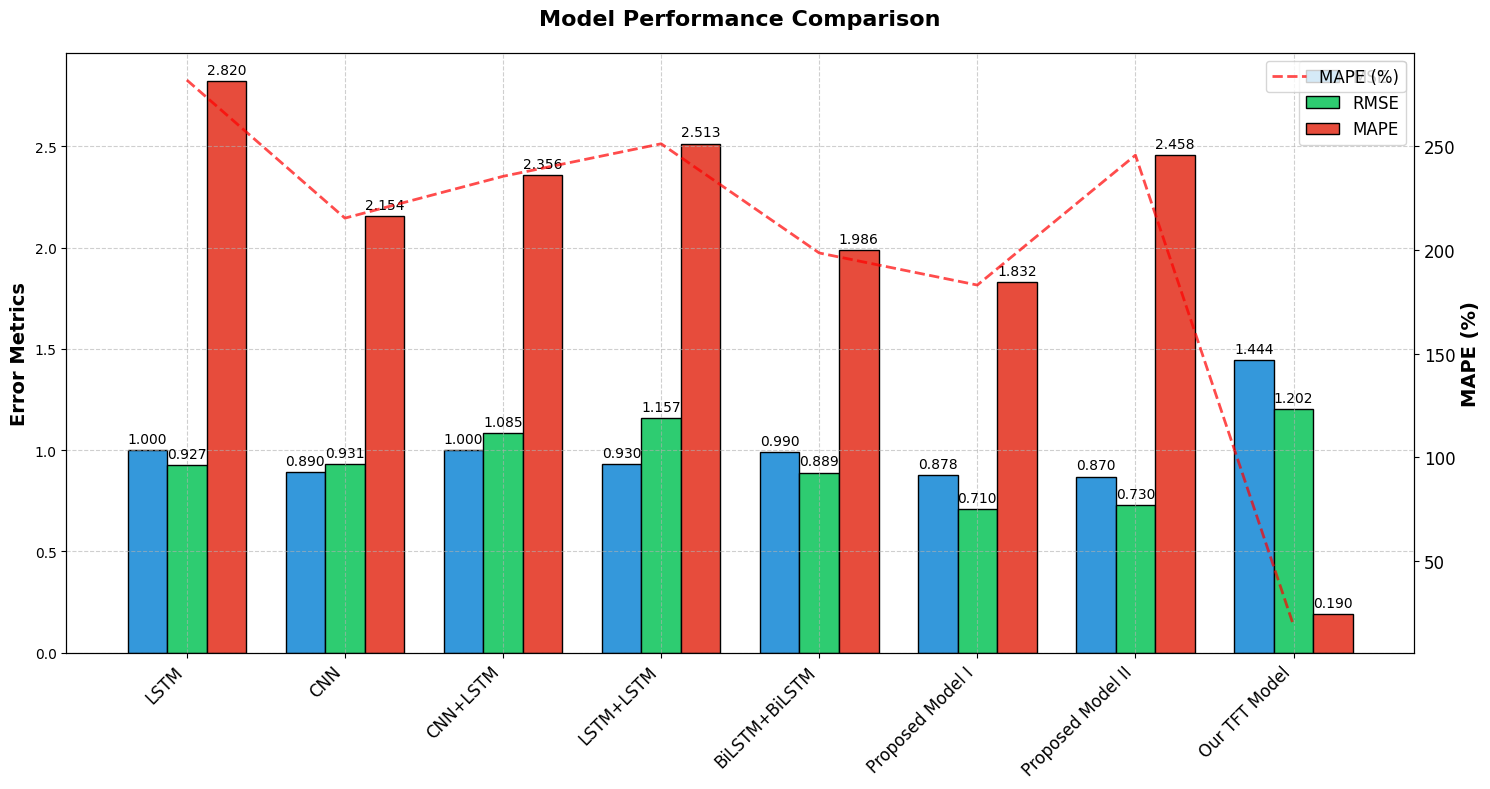

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['LSTM', 'CNN', 'CNN+LSTM', 'LSTM+LSTM', 'BiLSTM+BiLSTM', 'Proposed Model I', 'Proposed Model II', 'Our TFT Model']
mse_values = [1.000, 0.890, 1.000, 0.930, 0.990, 0.878, 0.870, 1.444]
rmse_values = [0.927, 0.931, 1.085, 1.157, 0.889, 0.710, 0.730, 1.202]
mape_values = [282.03, 215.44, 235.6, 251.3, 198.63, 183.16, 245.81, 18.97]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 8))

rects1 = ax.bar(x - width, mse_values, width, label='MSE', color='#3498db', edgecolor='black', linewidth=1)
rects2 = ax.bar(x, rmse_values, width, label='RMSE', color='#2ecc71', edgecolor='black', linewidth=1)
rects3 = ax.bar(x + width, np.array(mape_values)/100, width, label='MAPE', color='#e74c3c', edgecolor='black', linewidth=1)

ax.set_ylabel('Error Metrics', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)

ax2 = ax.twinx()
ax2.set_ylabel('MAPE (%)', fontsize=14, fontweight='bold')
ax2.plot(x, mape_values, 'r--', alpha=0.7, linewidth=2, label='MAPE (%)')
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(loc='upper right', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.6)

def add_value_labels(rects, ax):
    """اضافه کردن مقادیر به بالای ستون‌ها."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # فاصله از بالا
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_value_labels(rects1, ax)
add_value_labels(rects2, ax)
add_value_labels(rects3, ax)

plt.tight_layout()

plt.show()